# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

/Users/yaksenov/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California ho

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.74039861930404

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from tqdm.notebook import tqdm

In [126]:
def compute_bias_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y)

    preds_sum_per_obj = np.zeros((X_df.shape[0], 1))
    squared_preds_sum_per_obj = np.zeros((X_df.shape[0], 1))
    preds_quantity_per_obj = np.zeros((X_df.shape[0], 1))
    all_preds_quantity = 0
    error = 0.0

    for _ in tqdm(range(num_runs)):
        mask = np.random.choice(np.arange(X_df.shape[0]), size=X_df.shape[0], replace=True)
        X_boot = X_df.iloc[mask].copy()
        y_boot = y_df.iloc[mask].copy()
        regressor.fit(X_boot, np.array(y_boot).ravel())
        y_pred = regressor.predict(X_df).reshape(-1, 1)

        preds_sum_per_obj += y_pred * (~y_df.index.isin(mask)).reshape(-1, 1)
        squared_preds_sum_per_obj += y_pred**2 * (~y_df.index.isin(mask)).reshape(-1, 1)
        preds_quantity_per_obj += (~y_df.index.isin(mask)).reshape(-1, 1)
        error += np.sum((y_df[~y_df.index.isin(mask)] - y_pred[~y_df.index.isin(mask)])**2)
        all_preds_quantity += np.sum(~y_df.index.isin(mask))

    error = error / all_preds_quantity
    bias = np.mean((preds_sum_per_obj / preds_quantity_per_obj - y_df)**2, axis=0)
    variance = np.mean(squared_preds_sum_per_obj / preds_quantity_per_obj - (preds_sum_per_obj / preds_quantity_per_obj)**2, axis=0)
    return bias.item(), variance.item(), error.item()

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [19]:
clf = LinearRegression()
compute_bias_variance(clf, X, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

(23.754194414177476, 0.9413272694619479, 24.78458353011832)

In [20]:
clf = DecisionTreeRegressor()
compute_bias_variance(clf, X, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

(10.01779293949503, 13.035332687590088, 23.17013541588176)

In [21]:
clf = RandomForestRegressor()
compute_bias_variance(clf, X, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

(10.709507565815965, 2.2958610560265793, 12.933673649168906)

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Линейная регрессия дает большее смещение, чем дерево решений и случайный лес, но при этом самый маленький разброс, так как алгоритм линейной регрессии не так сильно зависит от обучающей выборки как деревья, но не способен так сильно подогнаться под обучающую выборку). Как и ожидалось, случайный лес благодаря уменьшенной корреляции базовых алгоритмов (деревьев решений) получил уменьшение дисперсии примерно в 10 раз (хотя в теории так как количество деревьев равно 100 мог дать уменьшение вплоть до 100 раз) при том же смещении (выборки были разные, поэтому смещения не совпали, но теоретически должны были).__

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [25]:
from sklearn.ensemble import BaggingRegressor

In [26]:
clf = BaggingRegressor(base_estimator=LinearRegression(), random_state=42)
compute_bias_variance(clf, X, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

(23.727918312166228, 1.0355938845200554, 24.89343469353957)

In [27]:
clf = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)
compute_bias_variance(clf, X, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

(10.511411768371081, 3.348914004102869, 13.877220501299146)

In [28]:
clf = BaggingRegressor(base_estimator=RandomForestRegressor(), random_state=42)
compute_bias_variance(clf, X, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

(11.650956656420133, 1.387435335121969, 13.121258612949722)

__В теории беггинг уменьшает разброс в N раз при нулевой корреляции базовых моделей. В случае с линейной регрессией разброс остался таким же, так как модели сильно коррелируют, но справедливости ради разброс линейных моделей и так низкий. Решающие деревья меньше коррелируют и удалось в 4 раза уменьшить их дисперсию (при том что количество моделей в ансамбле стоит 10, то есть в идеале уменьшилось бы в 10 раз). Случайные леса коррелируют сильнее, поэтому их дисперсия уменьшилась только в 2 раза. Но при этом все равно беггинг случайного леса дает наилучший результат по разбросу и ошибке.__

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [123]:
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor

In [54]:
def get_preds(regressor, X_train, y_train, X_test, num_runs):
    preds_for_test = np.empty((X_test.shape[0], 0))

    for _ in tqdm(range(num_runs)):
        mask = np.random.choice(np.arange(X_train.shape[0]), size=X_train.shape[0], replace=True)
        X_boot = X_train.iloc[mask].copy()
        y_boot = y_train.iloc[mask].copy()
        regressor.fit(X_boot, np.array(y_boot).ravel())
        preds_for_test = np.hstack((preds_for_test, regressor.predict(X_test).reshape(-1, 1)))

    return preds_for_test

In [112]:
def plot_predictions(regressor, X, y, ax, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y)
    np.random.seed(42)
    test_mask = np.random.choice(X.shape[0], size=num_test_objects)
    y_pred = get_preds(regressor, X_df[~X_df.index.isin(test_mask)], y_df[~y_df.index.isin(test_mask)], X_df.iloc[test_mask], num_runs)
    sns.set_style('darkgrid')
    sns.scatterplot(ax=ax, data=np.hstack((y_pred, y_df.iloc[test_mask])), legend=False, palette=['green'] * num_runs + ['black']).set_title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

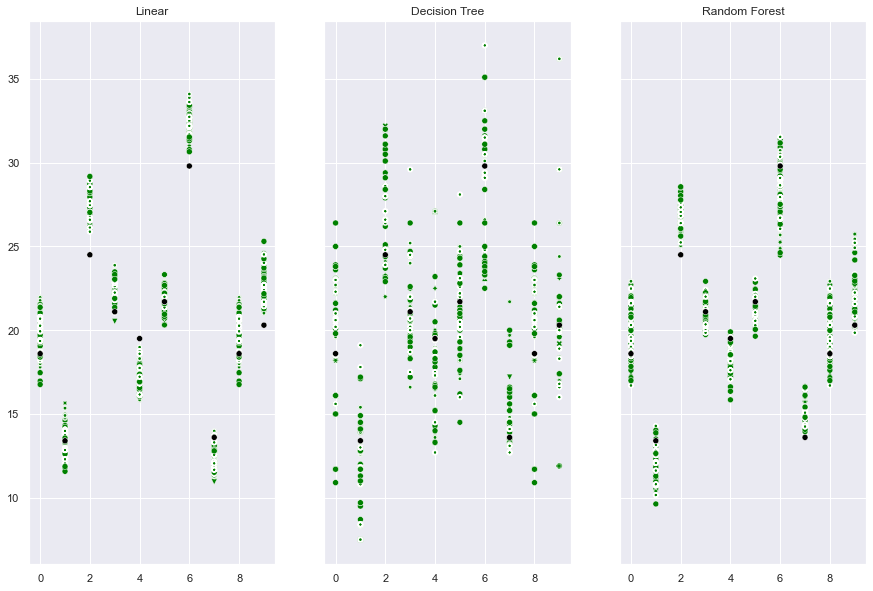

In [114]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)
plot_predictions(LinearRegression(), X, y, title='Linear', ax=axes[0])
plot_predictions(DecisionTreeRegressor(), X, y, title='Decision Tree', ax=axes[1])
plot_predictions(RandomForestRegressor(), X, y, title='Random Forest', ax=axes[2])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Как видим, линейная регрессия имеет на некоторых объектах сильное смещение ответов от реального, но при этом ответы расположены кучкообразно с низким разбросом, как и было получено в предыдущих пунктах. Дерево решений дает смещение меньше, но ответы расположены далеко друг от друга, поэтому разброс высокий. Случайный лес совмещает в себе положительные стороны 1 и 2 алгоритмов: у него ответы базовых моделей имеют низкий разброс и достаточно точно кучкуются вокруг реального ответа.__

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:>

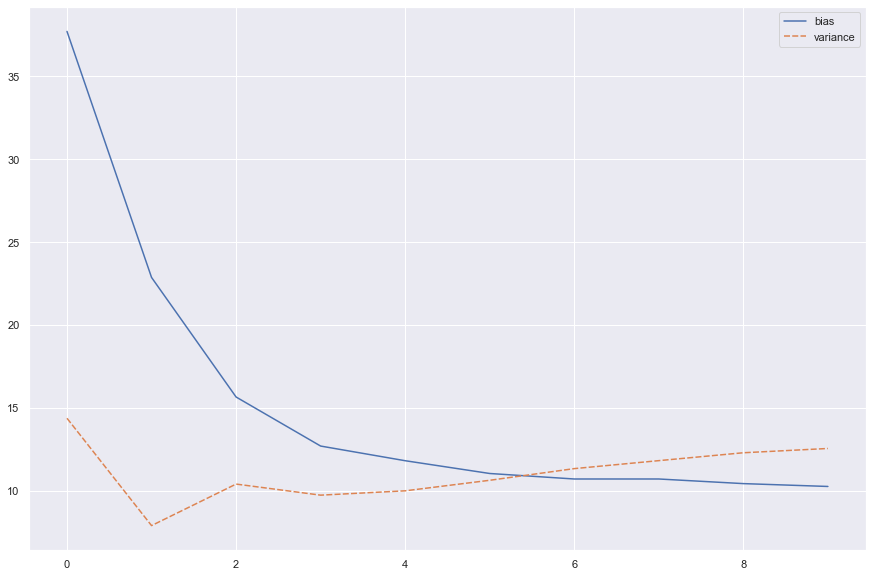

In [121]:
bias_var = {
    'bias': [],
    'variance': []
}

for max_depth in np.arange(1, 11):
    bias, variance, _ = compute_bias_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)
    bias_var['bias'].append(bias)
    bias_var['variance'].append(variance)

sns.set(rc={'figure.figsize': (15, 10)})
sns.lineplot(data=bias_var)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:>

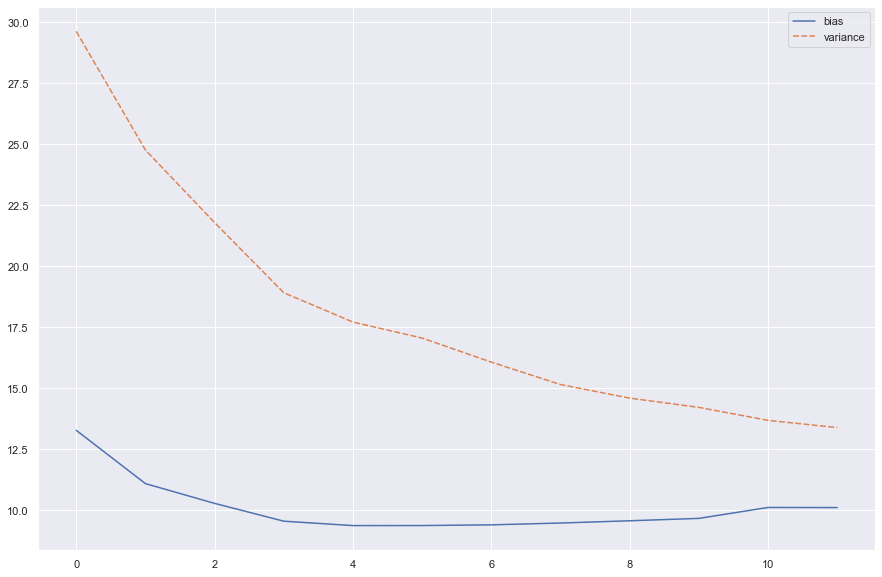

In [122]:
bias_var = {
    'bias': [],
    'variance': []
}

for max_features in np.arange(1, X.shape[1]):
    bias, variance, _ = compute_bias_variance(DecisionTreeRegressor(max_features=max_features), X, y)
    bias_var['bias'].append(bias)
    bias_var['variance'].append(variance)

sns.set(rc={'figure.figsize': (15, 10)})
sns.lineplot(data=bias_var)

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'RandomForestRegressor')

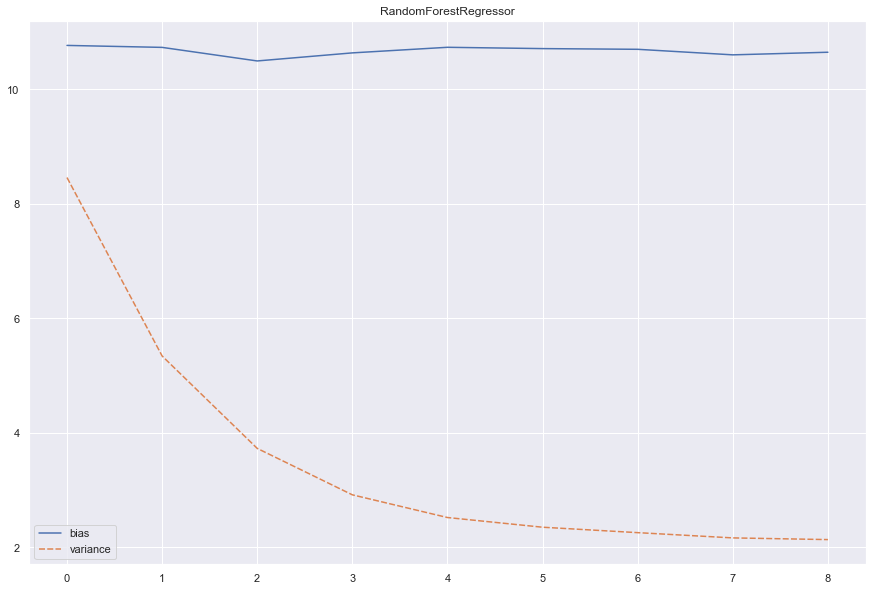

In [124]:
bias_var = {
    'bias': [],
    'variance': []
}

for n_estimators in 2**np.arange(1, 10):
    bias, variance, _ = compute_bias_variance(RandomForestRegressor(n_estimators=n_estimators), X, y)
    bias_var['bias'].append(bias)
    bias_var['variance'].append(variance)

sns.set(rc={'figure.figsize': (15, 10)})
sns.lineplot(data=bias_var).set_title('RandomForestRegressor')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'GradientBoostingRegressor')

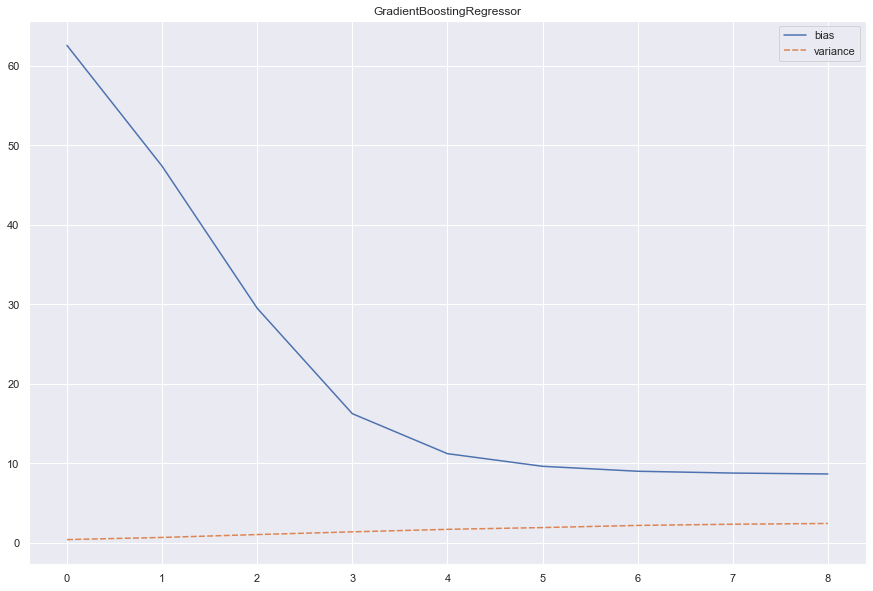

In [125]:
bias_var = {
    'bias': [],
    'variance': []
}

for n_estimators in 2**np.arange(1, 10):
    bias, variance, _ = compute_bias_variance(GradientBoostingRegressor(n_estimators=n_estimators), X, y)
    bias_var['bias'].append(bias)
    bias_var['variance'].append(variance)

sns.set(rc={'figure.figsize': (15, 10)})
sns.lineplot(data=bias_var).set_title('GradientBoostingRegressor')

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.


1. По первому графику видим, что при увеличении ```max_depth``` дерево сильнее подгоняется под обучающую выборку, поэтому bias постепенно падает, в то же время, чем больше у дерева глубина и, соответственно, листьев, тем более модель чувствительна к обучающей выборке, поэтому variance немного растет.
2. На втором графике при малых ```max_features``` модель плохо обучается, так в каждой вершине делает жадный алгоритм только по какому-то одному случайному признаку из всех. При увеличении ```max_features``` смещение падает и остается примерно таким же все время. Разброс убывает постепенно на всем графике, так как мы даем модели возможность точнее подбирать наиболее оптимальный предикат в каждой вершине, соответственно от модели к модели в связи с тем, что признаки по которым происходит перебор с большей вероятностью совпадают, разброс уменьшается.
3. На третьем графике при всех ```n_estimators``` смещение остается одинаковым, так как при беггинге смещение равно смещению базового алгоритма. Разброс постепенно снижается с ростом ```n_estimators```, так как при беггинге разброс уменьшается в лучшем случае в ```n_estimators``` раз.
4. В градиентном бустинге в композиции используются простые модели и неглубокие деревья, поэтому у них низкий разброс, так что на всем графике variance примерно одинаковый, при этом смещение очень большое. С увеличением ```n_estimators``` градиентным бустингом мы сильнее уменьшаем ошибку, поэтому падает и смещение.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

![](https://pyxis.nymag.com/v1/imgs/cbf/494/f9bed9bd63bf649f749f08f3f51312f0f6-office-christmas-lede.1x.rsquare.w1400.jpg)